# Import Library

In [19]:
!pip install gdown

In [20]:
# Library yang sering digunakan
import os, shutil
import gdown
import random
from random import sample
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px
from collections import Counter

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Gathering

In [22]:
!gdown https://drive.google.com/uc?id=1Ay0szCAF_aFZTjc0iObWUxB150OlugxI

Downloading...
From (original): https://drive.google.com/uc?id=1Ay0szCAF_aFZTjc0iObWUxB150OlugxI
From (redirected): https://drive.google.com/uc?id=1Ay0szCAF_aFZTjc0iObWUxB150OlugxI&confirm=t&uuid=ca46465e-a0a9-448d-86e6-127e89c52fce
To: /content/trashnet-merged.zip
100% 98.3M/98.3M [00:01<00:00, 72.6MB/s]


In [23]:
!unzip trashnet-merged.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: trashmerged/glass/brown-glass513.jpg  
  inflating: trashmerged/glass/brown-glass490.jpg  
  inflating: trashmerged/trash/trash266.jpg  
  inflating: trashmerged/glass/brown-glass511.jpg  
  inflating: trashmerged/glass/brown-glass501.jpg  
  inflating: trashmerged/glass/brown-glass57.jpg  
  inflating: trashmerged/glass/brown-glass443.jpg  
  inflating: trashmerged/glass/brown-glass600.jpg  
  inflating: trashmerged/glass/brown-glass473.jpg  
  inflating: trashmerged/glass/brown-glass499.jpg  
  inflating: trashmerged/glass/brown-glass545.jpg  
  inflating: trashmerged/glass/brown-glass46.jpg  
  inflating: trashmerged/glass/brown-glass494.jpg  
  inflating: trashmerged/glass/brown-glass493.jpg  
  inflating: trashmerged/glass/brown-glass512.jpg  
  inflating: trashmerged/glass/brown-glass483.jpg  
  inflating: trashmerged/glass/brown-glass447.jpg  
  inflating: trashmerged/glass/brown-glass58.jpg  
  inflating: t

# Exploratory Data Analysis

In [27]:
BASE_DIR = "/content/trashmerged"

## Distribusi Gambar per Kelas

In [28]:
# Buat daftar yang menyimpan data
file_name = []
labels = []
full_path = []

# Looping file
for path, subdirs, files in os.walk(BASE_DIR):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Buat dataframe
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi dengan Plotly
fig = px.histogram(
    distribution_train,
    x='labels',
    color='labels',
    title='Distribusi Gambar per Kelas',
    labels={'labels': 'Kelas'},
    text_auto=True
)

# Update layout (opsional)
fig.update_layout(
    xaxis_title="Kelas",
    yaxis_title="Jumlah Gambar",
    showlegend=False
)

fig.show()

## Menampilkan Sampel Setiap Kelas

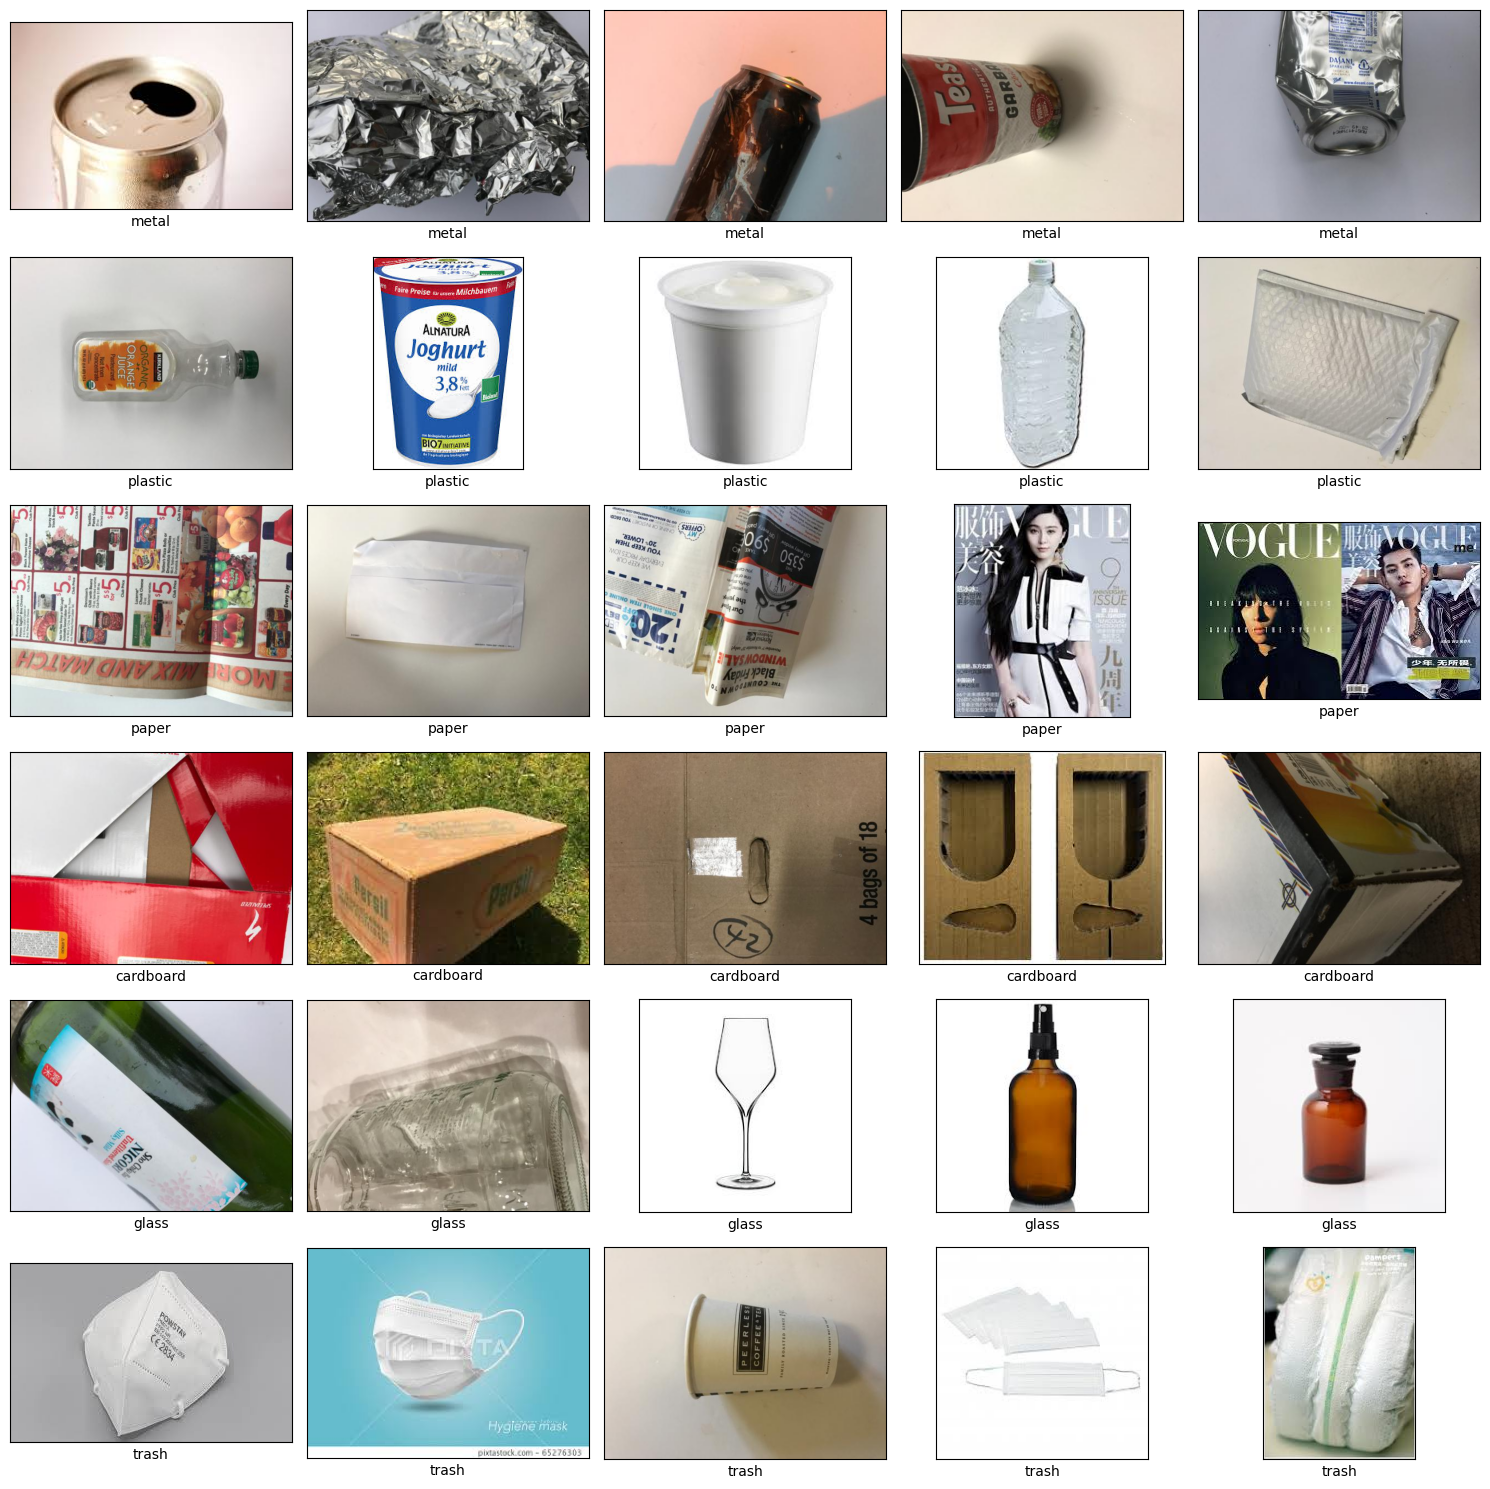

In [29]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
trash_image = {}

for i in os.listdir(BASE_DIR):
    trash_image[i] = os.listdir(os.path.join(BASE_DIR, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(trash_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(BASE_DIR)):
    images = np.random.choice(trash_image[class_name], 5, replace=False)

    # print(trash_image.keys())

    for j, image_name in enumerate(images):
        img_path = os.path.join(BASE_DIR, class_name, image_name)
        img = Image.open(img_path) # .convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## Mendapatkan Metadata Gambar

In [30]:
def get_image_metadata(dataset_path):
    data = []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue
        for fname in os.listdir(label_path):
            fpath = os.path.join(label_path, fname)
            try:
                with Image.open(fpath) as img:
                    width, height = img.size
                    mode = img.mode
                data.append({
                    'filepath': fpath,
                    'label': label,
                    'width': width,
                    'height': height,
                    'mode': mode
                })
            except:
                print(f"Corrupted image: {fpath}")
    return pd.DataFrame(data)

df = get_image_metadata(BASE_DIR)
df.head()

,filepath,label,width,height,mode
0,/content/trashmerged/metal/Copy of metal166.jpg,metal,512,384,RGB
1,/content/trashmerged/metal/metal582.jpg,metal,253,199,RGB
2,/content/trashmerged/metal/metal236.jpg,metal,512,384,RGB
3,/content/trashmerged/metal/metal299.jpg,metal,512,384,RGB
4,/content/trashmerged/metal/Copy of metal91.jpg,metal,512,384,RGB


## Cek Distribusi Ukuran Gambar

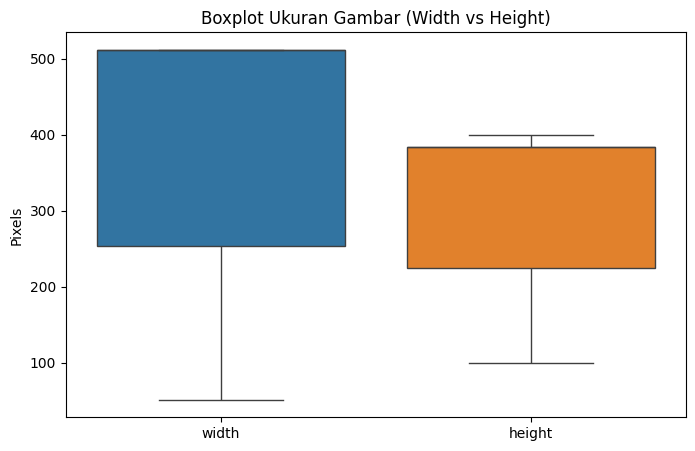

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['width', 'height']])
plt.title("Boxplot Ukuran Gambar (Width vs Height)")
plt.ylabel("Pixels")
plt.show()

In [32]:
# --- Step 1: Hitung ukuran gambar ---
sizes = []
class_names = [folder for folder in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, folder))]

for class_name in class_names:
    class_folder = os.path.join(BASE_DIR, class_name)
    for fname in os.listdir(class_folder):
        file_path = os.path.join(class_folder, fname)
        try:
            with Image.open(file_path) as img:
                sizes.append(img.size)  # (width, height)
        except Exception as e:
            print(f"Gagal membaca {file_path}: {e}")

# --- Step 2: Analisis dasar ---
size_counts = Counter(sizes)
print("Ukuran unik dan jumlahnya:", size_counts)
print("Total gambar:", len(sizes))

square_count = sum([1 for s in sizes if s[0] == s[1]])
print(f"Jumlah gambar square (panjang=lebar): {square_count} dari {len(sizes)} gambar")

if len(size_counts) == 1:
    print("Semua gambar memiliki ukuran yang seragam:", list(size_counts.keys())[0])
else:
    print("Terdapat lebih dari satu ukuran gambar!")

# --- Step 3: Siapkan data untuk Pie Chart 3 Bagian ---
# Convert Counter ke DataFrame
size_df = pd.DataFrame({
    'size': [f"{w}x{h}" for (w, h) in size_counts.keys()],
    'count': list(size_counts.values())
})

# Sort descending
size_df = size_df.sort_values(by='count', ascending=False)

# Ambil 2 ukuran terbesar
top2 = size_df.head(2)

# Hitung "Other"
other_count = size_df['count'].iloc[2:].sum()

# Buat DataFrame Pie Chart
pie_df = pd.DataFrame({
    'size': list(top2['size']) + ['Other'],
    'count': list(top2['count']) + [other_count]
})

# --- Step 4: Pie Chart dengan Plotly ---
fig = px.pie(
    pie_df,
    names='size',
    values='count',
    title='Distribusi Ukuran Gambar (Top 2 + Other)',
    hole=0.3
)

fig.update_traces(textinfo='percent+label')

fig.show()


Ukuran unik dan jumlahnya: Counter({(512, 384): 4404, (225, 225): 874, (275, 183): 199, (259, 194): 195, (300, 168): 66, (194, 259): 60, (183, 275): 46, (224, 224): 39, (276, 183): 22, (196, 257): 20, (201, 251): 19, (265, 190): 19, (299, 168): 19, (268, 188): 18, (225, 224): 17, (253, 199): 16, (274, 184): 16, (189, 267): 16, (256, 197): 14, (262, 193): 14, (200, 252): 14, (264, 191): 14, (260, 194): 13, (198, 255): 13, (188, 268): 13, (200, 200): 12, (217, 232): 12, (270, 187): 12, (269, 187): 12, (272, 185): 12, (310, 163): 12, (277, 182): 12, (198, 254): 12, (252, 200): 12, (262, 192): 11, (271, 186): 11, (261, 193): 11, (318, 159): 11, (251, 201): 11, (232, 217): 11, (191, 264): 11, (186, 271): 11, (263, 192): 11, (284, 177): 11, (266, 190): 10, (287, 176): 10, (246, 205): 10, (258, 195): 10, (280, 180): 10, (197, 256): 10, (184, 274): 10, (199, 254): 10, (240, 210): 9, (266, 189): 9, (248, 203): 9, (301, 167): 9, (199, 253): 9, (195, 258): 9, (193, 261): 9, (239, 211): 9, (190, 2

## Distribusi Mode Warna

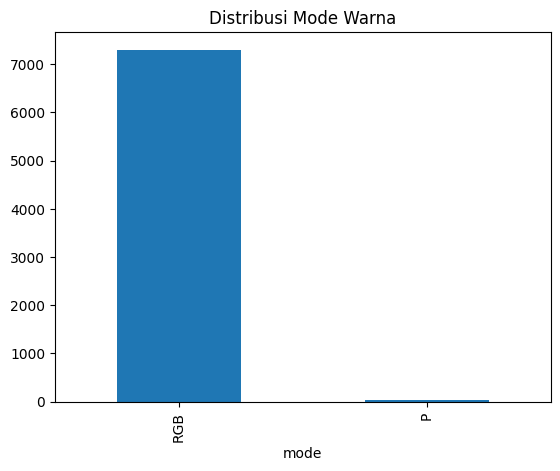

In [33]:
df['mode'].value_counts().plot(kind='bar', title="Distribusi Mode Warna")
plt.show()

Jumlah gambar dengan mode P: 27


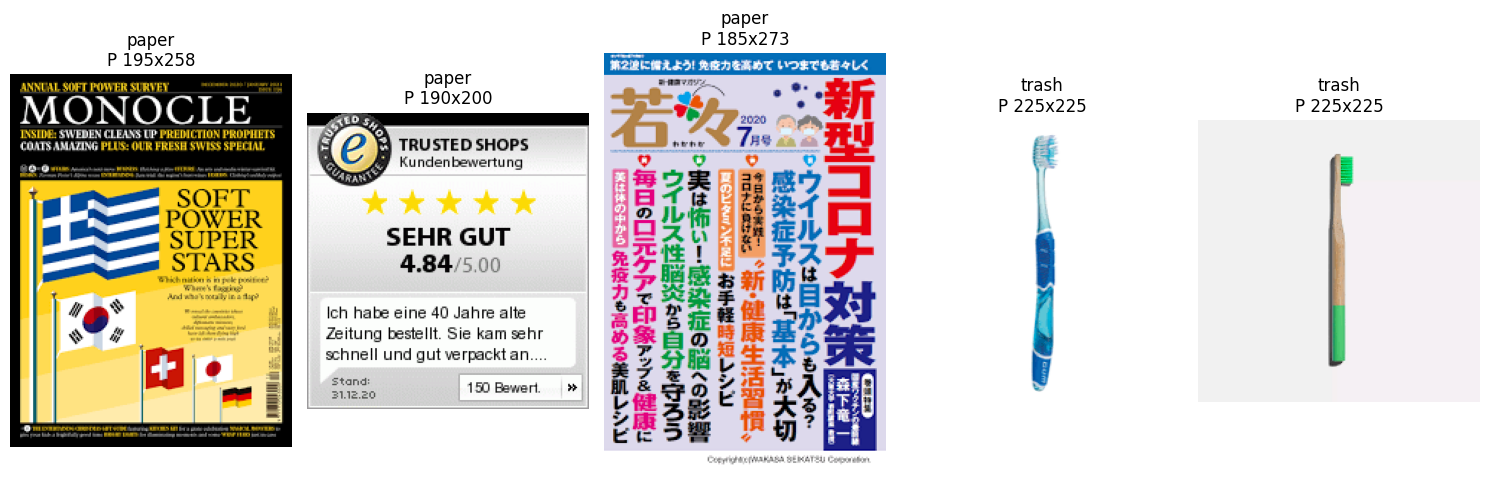

In [34]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Filter gambar dengan mode P
df_p = df[df['mode'] == 'P']

print(f"Jumlah gambar dengan mode P: {len(df_p)}")

# Step 2: Tampilkan beberapa gambar (misal 5 gambar pertama)
n_show = 5
sample_p = df_p.head(n_show)

# Step 3: Plot
plt.figure(figsize=(15, 5))

for i, row in enumerate(sample_p.itertuples(), 1):
    try:
        img = Image.open(row.filepath)
        plt.subplot(1, n_show, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{row.label}\n{row.mode} {row.width}x{row.height}")
    except Exception as e:
        print(f"Gagal membuka {row.filepath}: {e}")

plt.tight_layout()
plt.show()


## Cek File Rusak

In [35]:
bad_files = []
for f in df['filepath']:
    try:
        Image.open(f).verify()
    except:
        bad_files.append(f)
print(f"Jumlah file korup: {len(bad_files)}")

Jumlah file korup: 0
